# Brisket Performance Comparison

This notebook demonstrates the performance advantage of `brisket` over pure numpy implementations for one-hot encoding DNA sequences.

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from brisket import encode_seq

# Pure numpy implementation for comparison
def numpy_encode_seq(seq: str) -> np.ndarray:
    """Pure numpy implementation of one-hot encoding for DNA sequences."""
    seq = seq.upper()
    seq_len = len(seq)
    encoded = np.zeros((seq_len, 4), dtype=np.uint8)
    
    # Create mapping for bases
    base_to_idx = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
    for i, base in enumerate(seq):
        if base in base_to_idx:
            encoded[i, base_to_idx[base]] = 1
    
    return encoded

print("Brisket performance comparison initialized!")

Brisket performance comparison initialized!


In [2]:
# Generate test sequences of varying lengths
def generate_dna_sequence(length: int) -> str:
    """Generate a random DNA sequence of specified length."""
    bases = ['A', 'C', 'G', 'T']
    return ''.join(np.random.choice(bases, length))

# Test sequences of different lengths
sequence_lengths = [10000, 100000, 1000000, 10000000]
test_sequences = {length: generate_dna_sequence(length) for length in sequence_lengths}

print(f"Generated test sequences with lengths: {sequence_lengths}")

Generated test sequences with lengths: [10000, 100000, 1000000, 10000000]


In [3]:
# Performance benchmarking
def benchmark_function(func, seq, num_runs=100):
    """Benchmark a function by running it multiple times and returning average time."""
    times = []
    for _ in range(num_runs):
        start_time = time.perf_counter()
        result = func(seq)
        end_time = time.perf_counter()
        times.append(end_time - start_time)
    return np.mean(times), np.std(times), result

# Run benchmarks
results = {
    'brisket': {'times': [], 'stds': []},
    'numpy': {'times': [], 'stds': []}
}

print("Running performance benchmarks...")
print("Sequence Length | Brisket (ms) | NumPy (ms) | Speedup")
print("-" * 55)

for length in sequence_lengths:
    seq = test_sequences[length]
    
    # Benchmark brisket
    brisket_time, brisket_std, brisket_result = benchmark_function(encode_seq, seq)
    
    # Benchmark numpy
    numpy_time, numpy_std, numpy_result = benchmark_function(numpy_encode_seq, seq)
    
    # Verify results are identical
    assert np.array_equal(brisket_result, numpy_result), f"Results differ for length {length}"
    
    # Store results
    results['brisket']['times'].append(brisket_time * 1000)  # Convert to ms
    results['brisket']['stds'].append(brisket_std * 1000)
    results['numpy']['times'].append(numpy_time * 1000)
    results['numpy']['stds'].append(numpy_std * 1000)
    
    speedup = numpy_time / brisket_time
    
    print(f"{length:11d} | {brisket_time*1000:8.2f} ± {brisket_std*1000:.2f} | {numpy_time*1000:7.2f} ± {numpy_std*1000:.2f} | {speedup:.1f}x")

print(f"\nOverall speedup range: {min(np.array(results['numpy']['times']) / np.array(results['brisket']['times'])):.1f}x - {max(np.array(results['numpy']['times']) / np.array(results['brisket']['times'])):.1f}x")

Running performance benchmarks...
Sequence Length | Brisket (ms) | NumPy (ms) | Speedup
-------------------------------------------------------
      10000 |     0.07 ± 0.01 |    0.97 ± 0.03 | 13.1x
     100000 |     0.63 ± 0.03 |    9.76 ± 0.16 | 15.5x
    1000000 |     6.60 ± 0.17 |   99.50 ± 6.93 | 15.1x
   10000000 |    67.87 ± 6.14 | 1009.71 ± 21.72 | 14.9x

Overall speedup range: 13.1x - 15.5x


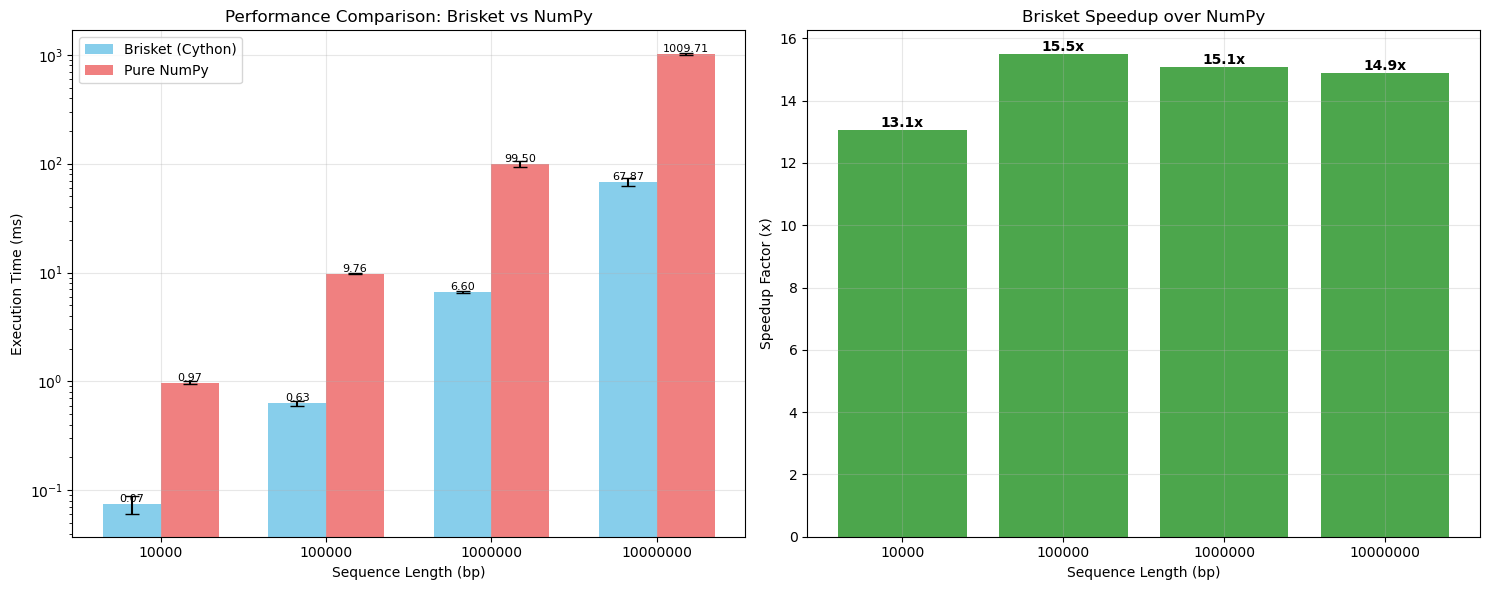

In [6]:
# Create performance visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Execution time comparison
x_pos = np.arange(len(sequence_lengths))
width = 0.35

brisket_times = np.array(results['brisket']['times'])
numpy_times = np.array(results['numpy']['times'])
brisket_stds = np.array(results['brisket']['stds'])
numpy_stds = np.array(results['numpy']['stds'])

bars1 = ax1.bar(x_pos - width/2, brisket_times, width, 
                yerr=brisket_stds, label='Brisket (Cython)', 
                color='skyblue', capsize=5)
bars2 = ax1.bar(x_pos + width/2, numpy_times, width, 
                yerr=numpy_stds, label='Pure NumPy', 
                color='lightcoral', capsize=5)

ax1.set_xlabel('Sequence Length (bp)')
ax1.set_ylabel('Execution Time (ms)')
ax1.set_title('Performance Comparison: Brisket vs NumPy')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(sequence_lengths)
ax1.legend()
ax1.set_yscale('log')  # Log scale to better show differences
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Speedup factor
speedups = numpy_times / brisket_times
bars3 = ax2.bar(np.arange(len(sequence_lengths)), speedups, color='green', alpha=0.7)
ax2.set_xlabel('Sequence Length (bp)')
ax2.set_ylabel('Speedup Factor (x)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(sequence_lengths)
ax2.set_title('Brisket Speedup over NumPy')
ax2.grid(True, alpha=0.3)

# Add value labels on speedup bars
for i, bar in enumerate(bars3):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}x', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()
